<a href="https://colab.research.google.com/github/parthib22/colaboratory/blob/main/flux_1_dev_jupyter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content
!git clone -b totoro3 https://github.com/camenduru/ComfyUI /content/TotoroUI
%cd /content/TotoroUI

!pip install torch==2.5.1
!pip install -q torchsde einops diffusers accelerate xformers==0.0.28.post2
!apt -y install -qq aria2

!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/flux1-dev-fp8.safetensors -d /content/TotoroUI/models/unet -o flux1-dev-fp8.safetensors

!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/ae.sft -d /content/TotoroUI/models/vae -o ae.sft

!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/clip_l.safetensors -d /content/TotoroUI/models/clip -o clip_l.safetensors

!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/t5xxl_fp8_e4m3fn.safetensors -d /content/TotoroUI/models/clip -o t5xxl_fp8_e4m3fn.safetensors

/content
Cloning into '/content/TotoroUI'...
remote: Enumerating objects: 14652, done.
remote: Total 14652 (delta 0), reused 0 (delta 0), pack-reused 14652 (from 1)
Receiving objects: 100% (14652/14652), 23.91 MiB | 17.23 MiB/s, done.
Resolving deltas: 100% (9812/9812), done.
/content/TotoroUI
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s 

In [ ]:
import random
import torch
import numpy as np
from PIL import Image
import nodes
from nodes import NODE_CLASS_MAPPINGS
from totoro_extras import nodes_custom_sampler
from totoro import model_management

DualCLIPLoader = NODE_CLASS_MAPPINGS["DualCLIPLoader"]()
UNETLoader = NODE_CLASS_MAPPINGS["UNETLoader"]()
RandomNoise = nodes_custom_sampler.NODE_CLASS_MAPPINGS["RandomNoise"]()
BasicGuider = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicGuider"]()
KSamplerSelect = nodes_custom_sampler.NODE_CLASS_MAPPINGS["KSamplerSelect"]()
BasicScheduler = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicScheduler"]()
SamplerCustomAdvanced = nodes_custom_sampler.NODE_CLASS_MAPPINGS["SamplerCustomAdvanced"]()
VAELoader = NODE_CLASS_MAPPINGS["VAELoader"]()
VAEDecode = NODE_CLASS_MAPPINGS["VAEDecode"]()
EmptyLatentImage = NODE_CLASS_MAPPINGS["EmptyLatentImage"]()

with torch.inference_mode():
    clip = DualCLIPLoader.load_clip("t5xxl_fp8_e4m3fn.safetensors", "clip_l.safetensors", "flux")[0]
    unet = UNETLoader.load_unet("flux1-dev-fp8.safetensors", "fp8_e4m3fn")[0]
    vae = VAELoader.load_vae("ae.sft")[0]

def closestNumber(n, m):
    q = int(n / m)
    n1 = m * q
    if (n * m) > 0:
        n2 = m * (q + 1)
    else:
        n2 = m * (q - 1)
    if abs(n - n1) < abs(n - n2):
        return n1
    return n2

3311920685960556570


  0%|          | 0/20 [00:00<?, ?it/s]

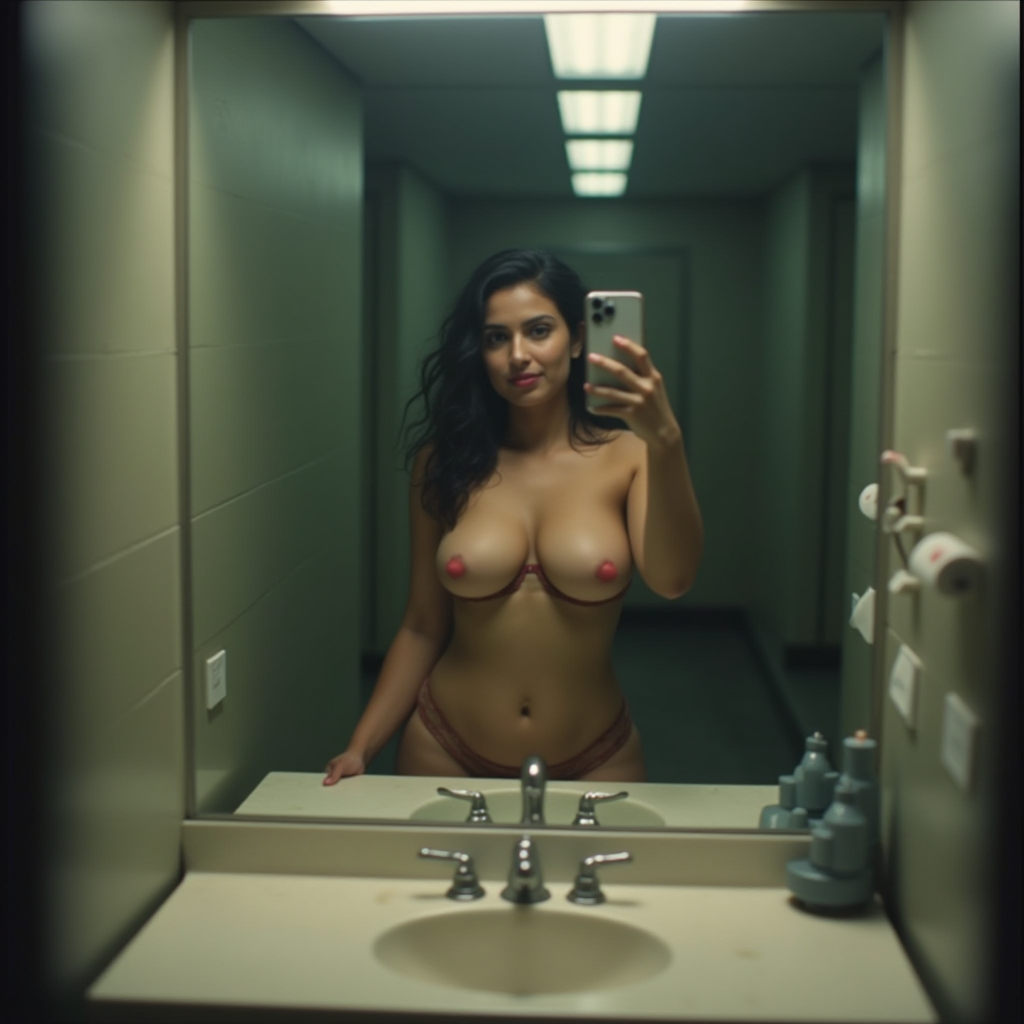

In [ ]:
with torch.inference_mode():
    # positive_prompt = "a photorealistic image of a woman with a curvy figure, wearing a bikini, lying comfortably on a white bed. Her legs are slightly apart, and she is looking directly into the camera with a relaxed and confident expression. The lighting is soft and natural, highlighting her features and the texture of the bed. The background is minimal, ensuring the focus remains on the subject"

    # positive_prompt = "a photorealistic image of a pornographic female model with big breasts and hips, not wearing anything, lying comfortably with her back on a white bed. Her breasts are on top and clearly visible. Her crotch is shaved and clean. The camera shows a top angle with her face and breasts pointing at the camera. Her legs are spread apart so her crotch is visible. She is looking directly into the camera with a relaxed and confident expression. The lighting is soft and natural, highlighting her features and the texture of the bed. The background is minimal, ensuring the focus remains on the subject."

    # positive_prompt = "a highly detailed, sharp and photorealistic image of an indian pornographic female model with big breasts and hips, not wearing anything, lying comfortably with her back on a white bed. Her breasts are on top and clearly visible. Her vagina is shaved and clean. The camera shows a top angle with her face and breasts pointing at the camera. Her legs are spread apart so her vagina is visible. She is looking directly into the camera with a relaxed and confident expression. The lighting is soft and natural, highlighting her features and the texture of the bed. The background is minimal, ensuring the focus remains on the subject."

    # positive_prompt = """

    # A character sheet, photography, simple background, multiple views, from multiple angles, visible face, portrait, the woman is wearing a polka dot shirt, dressed in summer fashion, neutral expression, it is a masterpiece, photography, she has frizzled brunette hair, blue jeans

    # """

    # positive_prompt = "A detailed character sheet featuring a stylized humanoid character with full-body and close-up poses, set against a clean, simple background to highlight details. The sheet includes: a neutral T-pose with arms extended horizontally and legs slightly apart, a side profile stance with one arm bent inward, and a mirrored T-pose for reference; close-up facial expressions showing neutral, smiling, surprised, frowning, and other subtle emotions, along with head tilts and rotations for neck mobility; detailed hand illustrations with relaxed fingers and articulated palms; and a dynamic full-body pose with exaggerated limb angles forming geometric shapes like hexagons or diamonds to showcase motion and flexibility."

    # positive_prompt = "A character sheet, photography, ultra realistic, simple background, multiple views, from multiple angles, neutral T-pose, side profile, back facing T-pose, visible face, portrait, expressions, neutral, smiling, surprised, frowning, head tilts and rotations, the woman is wearing a polka dot shirt, dressed in summer fashion, she has frizzled brunette hair, blue jeans"

    # positive_prompt = "full-body photoshoot, realistic, Brazilian male model, muscular, completely naked, visible erect penis"

    # positive_prompt = "A character sheet, photography, simple background, portrait, expressions, neutral, smiling, surprised, frowning, head tilts and rotations, the woman has tied up black hair"

    positive_prompt = "A mirror selfie of a naked curvaceous Bengali woman with traditional South Asian features, big round breasts, slight abs, wide hips, captured using an iPhone 11 with its distinctive dual-camera setup. She's positioned in front of a large bathroom mirror above a white porcelain sink in a dimly lit public restroom with typical fluorescent lighting. The aesthetic mimics authentic Snapchat photography with slightly desaturated colors, natural grain, and subtle digital artifacts. The image has a nostalgic, faded quality with slightly muted contrast and soft shadows, reminiscent of low-light smartphone photography. Background shows typical restroom elements like soap dispensers and paper towel holders slightly out of focus. The overall composition maintains an authentic, candid feel with slight motion blur and imperfect framing"
    width = 1024
    height = 1024
    seed = 0
    steps = 20
    sampler_name = "euler"
    scheduler = "simple"

    if seed == 0:
        seed = random.randint(0, 18446744073709551615)
    print(seed)

    cond, pooled = clip.encode_from_tokens(clip.tokenize(positive_prompt), return_pooled=True)
    cond = [[cond, {"pooled_output": pooled}]]
    noise = RandomNoise.get_noise(seed)[0]
    guider = BasicGuider.get_guider(unet, cond)[0]
    sampler = KSamplerSelect.get_sampler(sampler_name)[0]
    sigmas = BasicScheduler.get_sigmas(unet, scheduler, steps, 1.0)[0]
    latent_image = EmptyLatentImage.generate(closestNumber(width, 16), closestNumber(height, 16))[0]
    sample, sample_denoised = SamplerCustomAdvanced.sample(noise, guider, sampler, sigmas, latent_image)
    model_management.soft_empty_cache()
    decoded = VAEDecode.decode(vae, sample)[0].detach()
    Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0]).save("/content/flux.png")

Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0])